In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pydicom
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.9/269.9 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.20
    Uninstalling albucore-0.0.20:
      Successfully uninstalled albucore-0.0.20
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.21
    Uninstalling albumentations-1.4.21:
      Successfully uninstalled albumentations-1.4.21


In [3]:
# from torchvision import transforms, datasets
# from torch import nn

import sys
import os 
import numpy as np
from tqdm import tqdm,tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import PIL
import random
import pydicom as dicom
import pandas as pd

from matplotlib import pyplot as plt
# from torchvision import models, transforms
# from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

import albumentations as A
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# import torch_xla
# import torch_xla.core.xla_model as xm


In [6]:
class GaussianBlur(object):
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

In [8]:
s =1 
size = 112
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
data_transforms = transforms.Compose([v2.Resize((112,112)),
                                    v2.ToImage(),                                  
                                    
                                    v2.RandomResizedCrop(size=size),
                                    v2.RandomHorizontalFlip(),
                                    v2.RandomApply([color_jitter], p=0.8),
                                    v2.RandomGrayscale(p=0.2),
                                    # GaussianBlur(kernel_size=int(0.1 * size)),
                                    v2.ToDtype(torch.float32, scale=True),
                                    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                    v2.ToTensor()])

In [9]:
class SimCLRLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()

        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

def plot_features(model, dataloader, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for i, (x1,x2) in enumerate(dataloader):
            x1 = x1.squeeze().to(device = device, dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats, out, axis = 0)

            if i == 100:
              break

    tsne = TSNE(n_components = 2, perplexity = 50, verbose = 2)
    x_feats = tsne.fit_transform(feats)

    plt.scatter(x_feats[:, 1], x_feats[:, 0])
    plt.show()

In [10]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class ModelForPretraining(nn.Module):
    def __init__(self, projector_size):
        super().__init__()

        self.pretrained = torchvision.models.resnet18(pretrained=False)

        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        self.pretrained.fc = Identity()

        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = nn.Sequential(
            nn.Linear(512,300,bias=True),
            nn.ReLU(),
            nn.Linear(300, projector_size))

    def forward(self,x):
        out = self.pretrained(x)
        xp = self.projector(torch.squeeze(out))
        return xp

class ModelForFinetuning(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()

        self.premodel = pretrained_model
        self.num_classes = 2
        
        self.lastlayer = nn.Linear(512, self.num_classes)

    def forward(self,x):
        out = self.premodel.pretrained(x)
        out = self.lastlayer(out)
        return out

In [14]:
class TwoViewsDataset(torch.utils.data.Dataset):
  def __init__(self, source_dataset):
    self.source_dataset = source_dataset

  def __len__(self):
    return len(self.source_dataset)

  def __getitem__(self, idx):
    # each time is a different augmentation of the same image
    view1, _ = self.source_dataset[idx]
    view2, _ = self.source_dataset[idx]

    return view1, view2

In [13]:
dict_label={'Yes':1, 'No':0, 'Unknown':-1}

class SmokerDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.transforms=transforms
        self.df=df

    def __len__(self):
        # print(self.df.shape[0])
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        if str(self.df['filename'][idx]).endswith(".dcm"):
            new_img=dicom.dcmread('/kaggle/input/lastversion/clean_data/clean_data/'+str(self.df['filename'][idx]))
            new_img=new_img.pixel_array
            scaled_image = (np.maximum(new_img, 0) / new_img.max()) * 255.0
            scaled_image = np.uint8(scaled_image)
            img = PIL.Image.fromarray(scaled_image)
        else:
            img=PIL.Image.open('/kaggle/input/lastversion/clean_data/clean_data/'+str(self.df['filename'][idx]))        
        if self.transforms:
            img=self.transforms(img)
        # img=img.permute(1,2,0)
        # print(self.df['smoke'][idx])
        return img, dict_label[self.df['smoke'][idx]]

In [12]:
df_normal = pd.read_csv('/kaggle/input/lastversion/metadata_NORMAL.csv')
df_covid = pd.read_csv('/kaggle/input/lastversion/metadata_COVID.csv') 
df_pneumon = pd.read_csv('/kaggle/input/lastversion/metadata_PNEUMONIA.csv') 

# concatenate all dataframes/samples
df= pd.DataFrame(pd.concat([df_covid, df_normal, df_pneumon], axis=0))
df=df.reset_index(drop=True)


only_smoke_df=df[pd.isna(df['smoke'])==False]
# only_smoke_df.info()
only_smoke_df=only_smoke_df.reset_index(drop=True)

only_smoke_df = only_smoke_df[only_smoke_df['filename'] != 'Anonymous_04_0022_02.dcm']
only_smoke_df = only_smoke_df[only_smoke_df['filename'] != 'Anonymous_09_0068_02.dcm']
only_smoke_df = only_smoke_df[only_smoke_df['filename'] != 'Anonymous_09_0069_02.dcm']
only_smoke_df =only_smoke_df[only_smoke_df['quality']=='Good']
only_smoke_df=only_smoke_df.reset_index(drop=True)


unlabeled_data =df[pd.isna(df['smoke'])==True]
unlabeled_data=unlabeled_data.reset_index(drop=True)
unlabeled_data =unlabeled_data[unlabeled_data['quality']=='Good']


name_list = [f for f in os.listdir('/kaggle/input/lastversion/clean_data/clean_data/')]
unlabeled_data = unlabeled_data[unlabeled_data['filename'].isin(name_list)]
unlabeled_data=unlabeled_data.reset_index(drop=True)
unlabeled_data = unlabeled_data.fillna('Unknown')


train_clr, test_clr = train_test_split(unlabeled_data, test_size=0.16,shuffle=True)
train_clr=train_clr.reset_index(drop=True)
test_clr=test_clr.reset_index(drop=True)
# print(unlabeled_data.count())
# print(train_clr.count())
# print(test_clr.count())


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')


epochs = 20
nr = 10
learning_rate = 0.001
batchsize = 512


train_dataset=SmokerDataset(train_clr,transforms=data_transforms)
test_dataset=SmokerDataset(test_clr,transforms=data_transforms)


cifar_trainloader = DataLoader(TwoViewsDataset(source_dataset = train_dataset), batch_size=batchsize, shuffle=True, drop_last = True)
cifar_testloader = DataLoader(TwoViewsDataset(source_dataset = test_dataset), batch_size=batchsize, shuffle=True, drop_last = True)




model_for_pretraining = ModelForPretraining(projector_size = 64) # TODO might need some changes to the projector_size? Check the paper.



criterion = SimCLRLoss(batch_size = batchsize, temperature = 0.3 * batchsize/256)
optimizer = optim.AdamW(model_for_pretraining.parameters(), lr=learning_rate)

checkpoint = torch.load('/kaggle/input/mymodel/pytorch/default/2/best_model_14iter.model', weights_only=True)
model_for_pretraining.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
# print(last_epoch)


model_for_pretraining.to(device)

for epoch in range(last_epoch,epochs):
    
    print(f"Epoch [{epoch}/{epochs}]\t")
    model_for_pretraining.train()

    for step, (x_i, x_j) in enumerate(tqdm(cifar_trainloader, total = len(cifar_trainloader))):
        optimizer.zero_grad()

        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()

        # positive pair, with encoding
        z_i = model_for_pretraining(x_i)
        z_j = model_for_pretraining(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        # xm.optimizer_step(optimizer, barrier=True)

        if nr == 0 and step % 25 == 0:
            print(f"Step [{step}/{len(cifar_trainloader)}]\t Train Loss: {round(loss.item(), 5)}")

    model_for_pretraining.eval()
    # print("ceva")
    # Evaluation
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(tqdm(cifar_testloader, total = len(cifar_testloader))):

          x_i = x_i.squeeze().to(device).float()
          x_j = x_j.squeeze().to(device).float()

          # positive pair, with encoding
          z_i = model_for_pretraining(x_i)
          z_j = model_for_pretraining(x_j)

          loss = criterion(z_i, z_j)

          if nr == 0 and step % 25 == 0:
              print(f"Step [{step}/{len(cifar_testloader)}]\t Val Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()
    torch.save({
            'epoch': epoch,
            'model_state_dict': model_for_pretraining.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/kaggle/working/best_model.model')
    print(f"Epoch [{epoch}/{epochs}]")



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [14/20]	


  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [16]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    # model.cuda()
    model.train()
    running_loss, correct_preds, total = 0.0, 0, 0
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)
        # images = images.permute(0, 3, 1, 2)  # Adjust dimensions if necessary
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total
    return train_loss, train_accuracy

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct_preds, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(devoce)
            # images = images.permute(0, 3, 1, 2)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = correct_preds / total
    return val_loss, val_accuracy

def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # images = images.permute(0, 3, 1, 2)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs):
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

    # Main Function
def train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, device, 
                             criterion, optimizer, num_epochs=10, batch_size=32):
    # model.todevice()
    # Prepare DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        # val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        # val_losses.append(val_loss)
        # val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        
        # Save best model
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            torch.save(model.state_dict(), "best_model.pth")
    
    # Load the best model for testing
    model.load_state_dict(torch.load("best_model.pth"))
    
    # Test the model
    all_preds, all_labels = test_model(model, test_loader, device)
    
    # Metrics and classification report
    report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
    # Plot learning curves
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


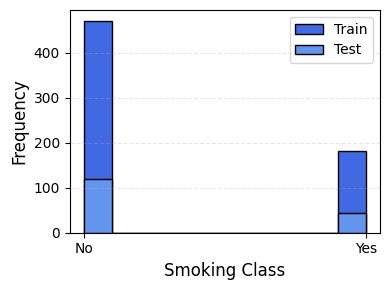

Epoch 1/10 - Train Loss: 0.6820, Train Acc: 0.6794
Epoch 2/10 - Train Loss: 0.6671, Train Acc: 0.6641
Epoch 3/10 - Train Loss: 0.6578, Train Acc: 0.6856
Epoch 4/10 - Train Loss: 0.6380, Train Acc: 0.6994
Epoch 5/10 - Train Loss: 0.6267, Train Acc: 0.6718
Epoch 6/10 - Train Loss: 0.6277, Train Acc: 0.6902
Epoch 7/10 - Train Loss: 0.6175, Train Acc: 0.7086
Epoch 8/10 - Train Loss: 0.5893, Train Acc: 0.7193
Epoch 9/10 - Train Loss: 0.6094, Train Acc: 0.7178
Epoch 10/10 - Train Loss: 0.5749, Train Acc: 0.7193


/tmp/ipykernel_23/1694720967.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


              precision    recall  f1-score   support

     Class 0       0.80      0.78      0.79       120
     Class 1       0.42      0.44      0.43        43

    accuracy                           0.69       163
   macro avg       0.61      0.61      0.61       163
weighted avg       0.70      0.69      0.70       163



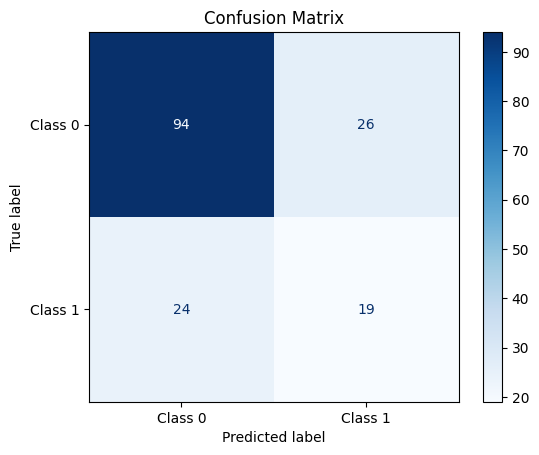

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

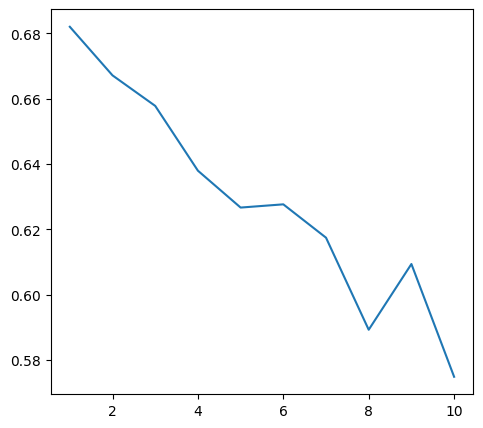

In [17]:
checkpoint = torch.load('/kaggle/input/mymodel/pytorch/default/1/best_model.model', weights_only=True)
model_for_pretraining.load_state_dict(checkpoint['model_state_dict'])

downstream_model = ModelForFinetuning(pretrained_model = model_for_pretraining)
downstream_model.to(device)

train_transform = transforms.Compose([
    # transforms.Grayscale(),
    # v2.Grayscale(),
    v2.Resize((112,112)),# rotire
    # v2.GaussianBlur(kernel_size=3),
    # v2.RandomRotation(degrees=13),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    v2.ToTensor()
    #
])

test_transform = transforms.Compose([
    # transforms.Grayscale(),
    # v2.Grayscale(),
    v2.Resize((112,112)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    v2.ToTensor()
    #
])



train, test = train_test_split(only_smoke_df, test_size=0.2,shuffle=True)
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

# train=oversample_minority_class(train, "smoke", "Yes")
# test=oversample_minority_class(test, "smoke", "Yes")
# val=oversample_minority_class(val, "smoke", "Yes")

plt.figure(figsize=(4, 3))
plt.hist(train['smoke'], bins=10, label="Train", color='royalblue', edgecolor='black')
plt.hist(test['smoke'], bins=10, label="Test", color='cornflowerblue', edgecolor='black')
# plt.hist(val['smoke'], bins=10, label="Validation", color='lightsteelblue', edgecolor='black')

plt.xlabel("Smoking Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

train_dataset= SmokerDataset(train, transforms=train_transform)
test_dataset=SmokerDataset(test, transforms=test_transform)

num_epochs = 15
batch_size = 64
best_val_loss = np.inf

weight = torch.tensor([0.33, 0.66],device=device) 
criterion = nn.CrossEntropyLoss(weight=weight)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(downstream_model.premodel.parameters(), lr=0.0001) #, betas=(0.9, 0.999)) # , weight_decay=1e-5



# all_preds, all_labels = test_model(downstream_model, DataLoader(test_dataset, batch_size=batch_size, shuffle=False), device)
    
# Metrics and classification report
# report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
# print(report)

# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
# plt.title("Confusion Matrix")
# plt.show()


train_and_evaluate_model(
    model=downstream_model,
    train_dataset=train_dataset,
    val_dataset=train_dataset,
    test_dataset=test_dataset,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    batch_size=32
)

